## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, regular, output_units=10, num_neurons=[512, 256, 128], ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regular(ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regular(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [11]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
regulars = [l1, l2, l1_l2]
for regular in regulars:
    for regulizer_ratio in L2_EXP:
        print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
        model = build_mlp(input_shape=x_train.shape[1:], regular=regular, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]
    
        exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
        results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}



W0722 21:57:59.114099 18292 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 21:57:59.165073 18292 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 21:57:59.182061 18292 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 21:57:59.273009 18292 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0722 21:57:59.2

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0722 21:57:59.423943 18292 deprecation.py:323] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0722 21:57:59.474895 18292 deprecation_wrapper.py:119] From C:\Users\user1\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 147us/step - loss: 198.6728 - acc: 0.2386 - val_loss: 41.0647 - val_acc: 0.2610
Epoch 2/50
50000/50000 [==============================] - 7s 133us/step - loss: 19.0920 - acc: 0.1148 - val_loss: 7.2727 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 7s 131us/step - loss: 4.1075 - acc: 0.0988 - val_loss: 2.6461 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 132us/step - loss: 2.4853 - acc: 0.0998 - val_loss: 2.4625 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 134us/step - loss: 2.4626 - acc: 0.0980 - val_loss: 2.4628 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.4626 - acc: 0.0970 - val_loss: 2.4627 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 131us/step - loss: 2.4626 - acc: 0.0993 - val_loss: 2.462

50000/50000 [==============================] - 7s 139us/step - loss: 6.0297 - acc: 0.2641 - val_loss: 5.8303 - val_acc: 0.3385
Epoch 2/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.7329 - acc: 0.3606 - val_loss: 5.6503 - val_acc: 0.3799
Epoch 3/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.5766 - acc: 0.3946 - val_loss: 5.5177 - val_acc: 0.4071
Epoch 4/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.4516 - acc: 0.4162 - val_loss: 5.3995 - val_acc: 0.4188
Epoch 5/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.3414 - acc: 0.4339 - val_loss: 5.2953 - val_acc: 0.4337
Epoch 6/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.2403 - acc: 0.4457 - val_loss: 5.2229 - val_acc: 0.4302
Epoch 7/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.1468 - acc: 0.4567 - val_loss: 5.1214 - val_acc: 0.4472
Epoch 8/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 131us/step - loss: 1.8061 - acc: 0.3662 - val_loss: 1.7623 - val_acc: 0.3854
Epoch 3/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.7225 - acc: 0.3968 - val_loss: 1.6931 - val_acc: 0.4077
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.6636 - acc: 0.4163 - val_loss: 1.6410 - val_acc: 0.4235
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.6181 - acc: 0.4309 - val_loss: 1.6060 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5789 - acc: 0.4433 - val_loss: 1.5754 - val_acc: 0.4450
Epoch 7/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.5452 - acc: 0.4579 - val_loss: 1.5544 - val_acc: 0.4488
Epoch 8/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.5168 - acc: 0.4678 - val_loss: 1.5323 - val_acc: 0.4635
Epoch 9/50
50000/50000 [=====================

50000/50000 [==============================] - 7s 133us/step - loss: 1.7308 - acc: 0.3941 - val_loss: 1.6912 - val_acc: 0.4121
Epoch 4/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.6697 - acc: 0.4152 - val_loss: 1.6449 - val_acc: 0.4279
Epoch 5/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.6202 - acc: 0.4317 - val_loss: 1.6047 - val_acc: 0.4398
Epoch 6/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5789 - acc: 0.4479 - val_loss: 1.5762 - val_acc: 0.4496
Epoch 7/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.5442 - acc: 0.4595 - val_loss: 1.5480 - val_acc: 0.4583
Epoch 8/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.5133 - acc: 0.4697 - val_loss: 1.5285 - val_acc: 0.4632
Epoch 9/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.4877 - acc: 0.4807 - val_loss: 1.5136 - val_acc: 0.4706
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 7s 136us/step - loss: 9.9213 - acc: 0.3992 - val_loss: 9.2810 - val_acc: 0.4073
Epoch 5/50
50000/50000 [==============================] - 7s 135us/step - loss: 8.7216 - acc: 0.4083 - val_loss: 8.1839 - val_acc: 0.4023
Epoch 6/50
50000/50000 [==============================] - 7s 134us/step - loss: 7.6986 - acc: 0.4159 - val_loss: 7.2425 - val_acc: 0.4180
Epoch 7/50
50000/50000 [==============================] - 7s 133us/step - loss: 6.8279 - acc: 0.4227 - val_loss: 6.4362 - val_acc: 0.4238
Epoch 8/50
50000/50000 [==============================] - 7s 131us/step - loss: 6.0835 - acc: 0.4294 - val_loss: 5.7487 - val_acc: 0.4343
Epoch 9/50
50000/50000 [==============================] - 7s 130us/step - loss: 5.4484 - acc: 0.4355 - val_loss: 5.1719 - val_acc: 0.4313
Epoch 10/50
50000/50000 [==============================] - 7s 131us/step - loss: 4.9050 - acc: 0.4397 - val_loss: 4.7004 - val_acc: 0.4240
Epoch 11/50
50000/50000 [===================

50000/50000 [==============================] - 7s 131us/step - loss: 1.7563 - acc: 0.4326 - val_loss: 1.7434 - val_acc: 0.4341
Epoch 6/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.7157 - acc: 0.4489 - val_loss: 1.7176 - val_acc: 0.4408
Epoch 7/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.6818 - acc: 0.4600 - val_loss: 1.6818 - val_acc: 0.4571
Epoch 8/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.6522 - acc: 0.4691 - val_loss: 1.6678 - val_acc: 0.4612
Epoch 9/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.6237 - acc: 0.4789 - val_loss: 1.6454 - val_acc: 0.4694
Epoch 10/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.5966 - acc: 0.4895 - val_loss: 1.6214 - val_acc: 0.4789
Epoch 11/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5728 - acc: 0.4975 - val_loss: 1.6258 - val_acc: 0.4782
Epoch 12/50
50000/50000 [==================

50000/50000 [==============================] - 7s 131us/step - loss: 1.5849 - acc: 0.4434 - val_loss: 1.5791 - val_acc: 0.4440
Epoch 7/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.5525 - acc: 0.4564 - val_loss: 1.5547 - val_acc: 0.4523
Epoch 8/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.5215 - acc: 0.4656 - val_loss: 1.5304 - val_acc: 0.4612
Epoch 9/50
50000/50000 [==============================] - 7s 130us/step - loss: 1.4925 - acc: 0.4760 - val_loss: 1.5098 - val_acc: 0.4683
Epoch 10/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.4661 - acc: 0.4867 - val_loss: 1.5005 - val_acc: 0.4750
Epoch 11/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.4424 - acc: 0.4955 - val_loss: 1.4733 - val_acc: 0.4815
Epoch 12/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.4191 - acc: 0.5020 - val_loss: 1.4759 - val_acc: 0.4769
Epoch 13/50
50000/50000 [=================

50000/50000 [==============================] - 7s 132us/step - loss: 1.5443 - acc: 0.4562 - val_loss: 1.5419 - val_acc: 0.4560
Epoch 8/50
50000/50000 [==============================] - 7s 134us/step - loss: 1.5132 - acc: 0.4675 - val_loss: 1.5387 - val_acc: 0.4553
Epoch 9/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4852 - acc: 0.4790 - val_loss: 1.5289 - val_acc: 0.4589
Epoch 10/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4595 - acc: 0.4849 - val_loss: 1.4837 - val_acc: 0.4749
Epoch 11/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4358 - acc: 0.4946 - val_loss: 1.4583 - val_acc: 0.4804
Epoch 12/50
50000/50000 [==============================] - 7s 132us/step - loss: 1.4123 - acc: 0.5018 - val_loss: 1.4421 - val_acc: 0.4894
Epoch 13/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.3914 - acc: 0.5105 - val_loss: 1.4625 - val_acc: 0.4800
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 8s 156us/step - loss: 2.4623 - acc: 0.0970 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 9/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4623 - acc: 0.0969 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 10/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4622 - acc: 0.0978 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 11/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4622 - acc: 0.0974 - val_loss: 2.4623 - val_acc: 0.1000
Epoch 12/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.4622 - acc: 0.0977 - val_loss: 2.4622 - val_acc: 0.1000
Epoch 13/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4621 - acc: 0.0976 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 14/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.4621 - acc: 0.0997 - val_loss: 2.4621 - val_acc: 0.1000
Epoch 15/50
50000/50000 [===============

50000/50000 [==============================] - 8s 154us/step - loss: 6.2638 - acc: 0.4281 - val_loss: 5.8941 - val_acc: 0.4301
Epoch 10/50
50000/50000 [==============================] - 8s 154us/step - loss: 5.5603 - acc: 0.4319 - val_loss: 5.2433 - val_acc: 0.4338
Epoch 11/50
50000/50000 [==============================] - 8s 158us/step - loss: 4.9615 - acc: 0.4351 - val_loss: 4.7114 - val_acc: 0.4293
Epoch 12/50
50000/50000 [==============================] - 8s 155us/step - loss: 4.4508 - acc: 0.4404 - val_loss: 4.2247 - val_acc: 0.4351
Epoch 13/50
50000/50000 [==============================] - 8s 155us/step - loss: 4.0180 - acc: 0.4416 - val_loss: 3.8296 - val_acc: 0.4331
Epoch 14/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.6511 - acc: 0.4441 - val_loss: 3.4916 - val_acc: 0.4395
Epoch 15/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.3403 - acc: 0.4460 - val_loss: 3.2036 - val_acc: 0.4460
Epoch 16/50
50000/50000 [==============

50000/50000 [==============================] - 8s 155us/step - loss: 4.9075 - acc: 0.4409 - val_loss: 4.6641 - val_acc: 0.4407
Epoch 11/50
50000/50000 [==============================] - 8s 156us/step - loss: 4.4436 - acc: 0.4467 - val_loss: 4.2411 - val_acc: 0.4432
Epoch 12/50
50000/50000 [==============================] - 8s 156us/step - loss: 4.0469 - acc: 0.4505 - val_loss: 3.8736 - val_acc: 0.4477
Epoch 13/50
50000/50000 [==============================] - 8s 157us/step - loss: 3.7060 - acc: 0.4557 - val_loss: 3.5614 - val_acc: 0.4451
Epoch 14/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.4149 - acc: 0.4589 - val_loss: 3.3164 - val_acc: 0.4482
Epoch 15/50
50000/50000 [==============================] - 8s 156us/step - loss: 3.1658 - acc: 0.4598 - val_loss: 3.0600 - val_acc: 0.4579
Epoch 16/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.9516 - acc: 0.4641 - val_loss: 2.8669 - val_acc: 0.4583
Epoch 17/50
50000/50000 [==============

50000/50000 [==============================] - 8s 157us/step - loss: 4.4426 - acc: 0.4448 - val_loss: 4.2388 - val_acc: 0.4446
Epoch 12/50
50000/50000 [==============================] - 8s 159us/step - loss: 4.0436 - acc: 0.4511 - val_loss: 3.8889 - val_acc: 0.4379
Epoch 13/50
50000/50000 [==============================] - 8s 157us/step - loss: 3.7038 - acc: 0.4544 - val_loss: 3.5554 - val_acc: 0.4546
Epoch 14/50
50000/50000 [==============================] - 8s 158us/step - loss: 3.4122 - acc: 0.4580 - val_loss: 3.2857 - val_acc: 0.4593
Epoch 15/50
50000/50000 [==============================] - 8s 155us/step - loss: 3.1620 - acc: 0.4618 - val_loss: 3.0619 - val_acc: 0.4579
Epoch 16/50
50000/50000 [==============================] - 8s 155us/step - loss: 2.9489 - acc: 0.4647 - val_loss: 2.8718 - val_acc: 0.4608
Epoch 17/50
50000/50000 [==============================] - 8s 156us/step - loss: 2.7658 - acc: 0.4682 - val_loss: 2.7027 - val_acc: 0.4593
Epoch 18/50
50000/50000 [==============

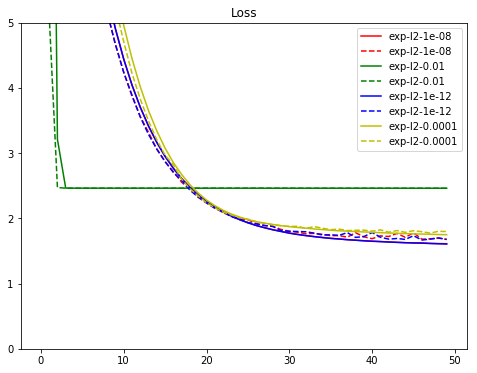

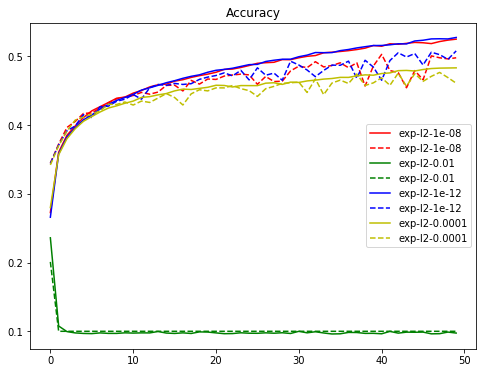

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%6])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%6])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%6])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%6])
plt.title("Accuracy")
plt.legend()
plt.show()